In [1]:
from keras.utils import image_dataset_from_directory

train_folder = "./chest_Xray/train/"
validation_folder = "./chest_Xray/val/"
testing_folder = "./chest_Xray/test"

#Les 3 lignes suivantes charges les images que l'on a dans les sous-dossier en dataset permettant l'entrainement, la validation et le test
#chacun de ces set possèdent 2 label qui correspondent aux nom des sous-dossier présent dans le dossier du chemin ci-dessus
#Dans notre cas, nous avons donc pour chaque dataset un label "NORMAL" et un label "PNEUMONIE"

#Le paramètre "subset" permet d'indiquer à l'algorithme qu'il s'agit du dataset d'entrainement ou de validation, le dataset de test ne possède pas de valeur 
#pour le paramètre subset

#le paramètre "validation_split" permet de mettre en place la "cross_validation", ça signifique que l'on va donner, dans notre cas 70% du dataset pour l'entrainement du réseau
#Les 30% restant serviront à valider les prédiction qu'il a essayer de faire

#La seed est un nombre défini arbitrairement qui va donner un générateur de nombre aléatoire qui définira quelles images sont sélectionnée pour les 70% d'entrainement
#Et pour les 30% de cross_validation
#Pour résumer, une même seed donnera la même sélection d'image à chaque entrainement et prédiction
training_set = image_dataset_from_directory(train_folder, color_mode="rgb", subset="training", validation_split=0.3, seed=42, image_size=(256, 256))
validation_set = image_dataset_from_directory(validation_folder, color_mode="rgb", subset="validation", validation_split=0.3, seed=42, image_size=(256, 256))
testing_set = image_dataset_from_directory(testing_folder, color_mode="rgb", seed=42, image_size=(256, 256))

Found 5216 files belonging to 2 classes.
Using 3652 files for training.
Found 16 files belonging to 2 classes.
Using 4 files for validation.
Found 624 files belonging to 2 classes.


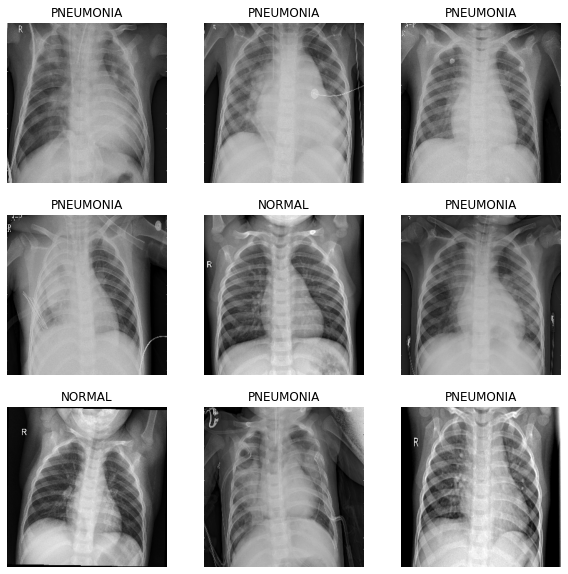

In [2]:
import matplotlib.pyplot as plt

class_names = training_set.class_names

#Ici on affiche simplement 9 image sélectionnées aléatoirement dans le dataset d'entrainement pour vérifier qu'elle sont bien charger et possèdent leur label
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1) :
    for i in range(9) :
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

In [3]:
#Ici on affiche la shape de notre training_set
#La shape se défini ainsi :
# - 32 : le nombre d'élément présent dans le set
# - 256 : la hauteur de l'image
# - 256 : la largeur de l'image
# - 3 : le nombre de couleurs du pixel, ici nous en somme en RGB donc 3 couleurs
for image_batch, labels_batch in training_set :
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [4]:
from tensorflow.data import AUTOTUNE
autotune = AUTOTUNE

training_set = training_set.cache().prefetch(buffer_size=autotune)
validation_set = validation_set.cache().prefetch(buffer_size=autotune)
testing_set = testing_set.cache().prefetch(buffer_size=autotune)

In [5]:
from tensorflow import keras

#Ici on construit le modèle de notre réseaux de neuronnes qui sera entrainé et servira pour faire les prédictions
model = keras.Sequential([
    
    #La layer Conv2D applique une "convolution" sur l'image qui lui est passée en entrée,
    #La convolution est le fait d'appliquer une petite matrice de nombre (par exemple de 3x3 nombre) qui parcoure l'image et effectue un produit scalaire
    #à chaque nouveau déplacement pour obtenir une valeur de pixel.
    
    #Le produit scalaire est le fait de multiplier 2 vecteurs puis d'additionner ces produits,
    #par exemple pour deux vecteurs V, et W un produit scalaire se traduit de la façon suivante :
    #V * W = V1 * W1 + V2 * W2 + ... + Vn * Wn
    #Ecris sous une autre forme, la formule du produit scalaire se présente ainsi :
    # V * W = ΣVi * Wi pour i allant de 1 à n
    
    #Ce processus peut être utilisé par exemple pour détecter les bords d'une images, ou des caractéristique propre à celle-ci
    #dans notre cas, cela peut permettre de détecter un ensemble de valeur de pixel caractéristique d'une pneumonie
    
    #Le 1er paramètre indique le nombre de convolution à faire, dans notre cas donc nous appliquons donc 32 convolution sur cette première couche
    #Le 2ème paramètre indique la taille de ces convolutions, que l'on appel "kernel", dans notre cas, ce "kernel" sera donc une matrice de taille 3x3
    
    #Enfin, le dernier paramètre est la fonction d'activation :
    #c'est la fonction dont le résultat déterminera si le neuronne est activé et si donc les données qu'il donne en sortie seront transmisent à la couche suivante
    keras.layers.Conv2D(32, (3,3), activation='sigmoid'),

    #La layer MaxPooling2D la taille spatiale (largeur et hauteur) de ce qui lui est passée en entrée
    #Pour ce faire, on applique de la même façon que pour la layer Conv2, une petite matrice (par exemple de taille 3, soit 3x3) sur le résultat fournis par la couche Conv2D
    #Cette matrice va récupérer la valeur maximale des pixel de chaque région dans laquelle elle passera
    #De cette façon, on réduit le nombre de données à traiter dans les prochaines couches, tout en conservant les données les plus importante
    #En effet, dans notre cas, les pixel représentant la présence d'une pneumonie seront sans doute ceux dont le passage de la Conv2D à donner les résultat les plus élevé
    #sur le produit scalaire
    
    #le paramètre passé dans cette couche est également appellée "kernel", soit la taille de la matrice utiliser dans le passage des données en entrée, 
    #dans notre cas donc, ce sera une matrice de 2x2
    keras.layers.MaxPooling2D((2,2)),
    
    #La couche de dropout est utiliser pour désactiver aléatoirement certain neuronnes de la couche précédente
    #Elle sert principalement à éviter le phénomène "d'overfitting" : le fait que le modèle tente "d'apprendre par coeur" les données d'entrainement
    #plutôt que d'en reconnaitre les pattern récurrant
    #Dans le cas ci-dessous, une couche dropout avec un paramètre de 0.2 signifie que le modèle désactivera aléatoirement 20% des neuronnes de la couche précédente
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3, 3), activation='sigmoid'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3, 3), activation='sigmoid'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(256, (3, 3), activation='sigmoid'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    #La couche Flatten est utilisée pour préparer les données passée en entrée par les couches précédentes afin de pouvoir les transmettres aux couches "Dense" qui prennent en entrée des vecteurs à une dimension
    #Cette couche transforme les matrices à 2 dimensions que nous avons dans les couches précédentes (les matrices qui représentes nos images sous forme de valeur de pixel)
    #En un vecteur à une seule dimension
    
    #plus précisément, nous couche précédente nous transmettent des matrices avec la shape suivante : (batch_size, height, width, channel),
    #Dans notre cas, la shape que nous avions au début du modèle étais (32, 256, 256, 3)
    #La couche Flatten va transformer cette matrice en multipliant les 3 dernière valeurs pour en obtenir une seule, donc dans notre cas :
    #Valeur d'entrée : (32, 256, 256, 3)
    #Calcul effectué dans la couche Flatten : (32, 256*256*3)
    #Valeur de sortie : (32, 196 608)
    #Ce que signifique ce vecteur est que nous avons 32 ligne de chacune 196 608 valeurs
    #Cela correspond grossièrement à l'utilisation de la fonction "reshape" de la libraire numpy que nous avons utiliser dans le bootstrap du projet
    keras.layers.Flatten(),

    #La couche "Dense" est utiliser pour connecter tout les neuronnes de la couches précédentes à tout les neuronnes de la couche suivante
    #Dans notre cas, nous avons donc 128 connections puisque la couche précédente compte 128 convolutions
    
    #La couche Dense produit en résultat un vecteur à 1 dimension après avoir effectué un calcul linéaire :
    #Ce calcul se définit comme le produit du vecteur que nous avons passé en entrée de cette couche, 
    #avec une matrice de poids qui est automatiquement générée par le modèle durant l'entrainement
    
    #Ce vecteur d'entrée est celui qui à été préparer par la couche Flatten que nous avons ci-dessus
    
    #Ensuite, le résultat de ce produit est utiliser dans une fonction d'activation, ici pour cette couche nous utilisont la fonction "relu"
    #Cette fonction d'activation prend en paramètre le résultat de notre produit précédent et un vecteur de biais, puis il additionne ces 2 paramètres
    
    #La matrice de poids et le vecteurs de biais sont des données générées automatiquement par le modèle qui lui permettent d'ajuster les valeurs de sortie de ses neuronnes et
    #de réduire les erreurs de prédiction
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    #Dans cette dernière couche Dense, nous ne fournissons que 2 neuronnes car en sortie du réseaux nous n'avons que 2 valeur possible : NORMAL ou PNEUMONIE
    #La fonction d'activation fournis est la fonction sigmoid car elle permet de récupérer une valeur entre 0 et 1 représentant la probabilité que l'image appartiennent
    #à la classe que l'on cherche à prédire
    
    #Par exemple dans notre cas, on souhaite prédire si une radio de poumons présente une Pneumonie, Si la fonction sigmoid nous renvoi un résultat proche de 0, alors cela signifie
    #Que la radio transmise en entrée du réseaux de neuronnes est probablement celle d'un poumon normal, à l'inverse, si elle renvoi un résultat proche de 1, alors il est fort probable
    #Que la radio indique la présence d'une Pneumonie
    keras.layers.Dense(2, activation='softmax')
])

In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
#La méthode suivante configure le modèle avec différents paramètre :
#optimizer : c'est une méthode d'optimisation de la recherche du minimum local :
#Ici on utilise l'optimiseur Adam qui se base sur une descente de gradient stochastique (cf. annexes pour l'explication du fonctionnement)
#Le but de l'optimiseur est de mettre à jour la matrice de poids du modèle au cours de l'apprentissage afin de converger vers le minimum local qui représente la solution au problème
#Le paramètre learning rate agis comme un pas que va utiliser l'optimiseur pour la mise à jour des poids,
#Un learning rate trop grand pourrait faire rater le minimum local, alors qu'un learning rate trop bas pourrais rendre sa recherche trop longue pour le modèle et donc il ne parviendrais pas à le trouver
#loss : c'est la fonction de perte, elle vérifie l'écart entre les valeurs prédites et les valeurs réelles
#metrics : les métrique que l'on souhaite évaluer, ici on cherche à mesurer l'exactitude des prédictions
model.compile(
optimizer=Adam(learning_rate=0.001),
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [7]:
#Ici on fait entrainer le modèle avec notre dataset d'entrainement et on lui passe le dataset de validation que l'on a charger au début du programme
#pour qu'il puisse valider ses prédictions

#5 epochs signifie qu'il va faire 5 passages d'entrainement sur le dataset avec à chaque nouvelle epoch, le résultat de l'epoch précédente
#Cela permet d'affiner les résultat et un apprentissage plus précis
history = model.fit(training_set,validation_data=validation_set,epochs=5)

Epoch 1/5
115/115 [==============================] - 293s 3s/step - loss: 0.8047 - accuracy: 0.6169 - val_loss: 0.9036 - val_accuracy: 0.5000
Epoch 2/5
115/115 [==============================] - 218s 2s/step - loss: 0.6708 - accuracy: 0.6862 - val_loss: 0.8733 - val_accuracy: 0.5000
Epoch 3/5
115/115 [==============================] - 216s 2s/step - loss: 0.6285 - accuracy: 0.7059 - val_loss: 0.8519 - val_accuracy: 0.5000
Epoch 4/5
115/115 [==============================] - 229s 2s/step - loss: 0.6187 - accuracy: 0.7152 - val_loss: 0.8388 - val_accuracy: 0.5000
Epoch 5/5
115/115 [==============================] - 231s 2s/step - loss: 0.6023 - accuracy: 0.7243 - val_loss: 0.8381 - val_accuracy: 0.5000


In [8]:
#Cette ligne nous donne tout les paramètres du modèle
#Le nom des couches
#La shape que possèderont les données en sortie de la couche
#Le nombre total de paramètre de la couche
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

20/20 [==============================] - 12s 446ms/step


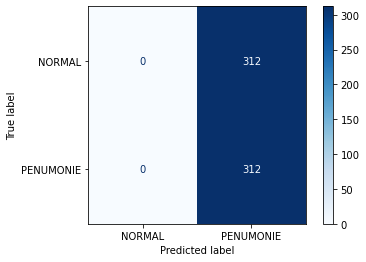

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convertir les labels en un format numérique
labels = ['NORMAL', 'PNEUMONIE']*312

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

predictions = model.predict(testing_set, workers=2, max_queue_size=10)
predicted_classes = np.argmax(predictions, axis=1)


# Calculer la matrice de confusion
cm = confusion_matrix(labels_encoded, predicted_classes)

# Afficher la matrice de confusion sous forme de heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PENUMONIE'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [10]:
#Cette ligne permet au modèle de s'évaluer sur le dataset de test et de vérifier s'il a bien été entrainer
#Par exemple, nous avons 90 % de précision annoncé par le modèle sur le dataset d'entrainement mais 78% sur celui de test
#Cette différence de précision peut traduire un problème d'overfitting :
#Lors de l'entrainement, la taille d'image pouvais être trop grande, ce qui fais que le modèle avais plus de pixel en entrée et à peut-être pu détecter des détails "en trop"
#Ce qui fait qu'il peut avoir assimiler des poumons normaux à des pneumonies et inversement
#Une solution pourrais être de réduire la taille des images en entrées pour réduire le nombre de pixel visible par le programme
result = model.evaluate(testing_set, verbose=1)

20/20 [==============================] - 9s 448ms/step - loss: 0.7002 - accuracy: 0.6250


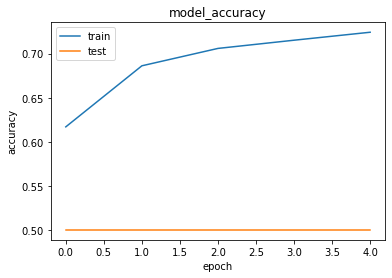

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

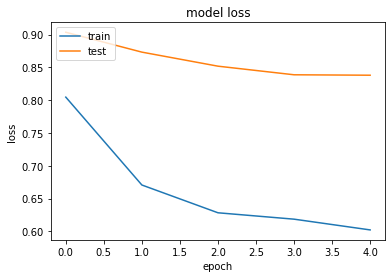

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
overfit_model = keras.models.load_model("CNN_model")

In [49]:
history = overfit_model.fit(training_set,validation_data=validation_set,epochs=5)

Epoch 1/5
115/115 [==============================] - 172s 1s/step - loss: 0.3632 - accuracy: 0.8853 - val_loss: 7.5311 - val_accuracy: 0.7500
Epoch 2/5
115/115 [==============================] - 177s 2s/step - loss: 0.2973 - accuracy: 0.8880 - val_loss: 5.4833 - val_accuracy: 0.7500
Epoch 3/5
115/115 [==============================] - 184s 2s/step - loss: 0.2417 - accuracy: 0.9110 - val_loss: 6.0986 - val_accuracy: 0.7500
Epoch 4/5
115/115 [==============================] - 179s 2s/step - loss: 0.2722 - accuracy: 0.9129 - val_loss: 3.8729 - val_accuracy: 0.7500
Epoch 5/5
115/115 [==============================] - 178s 2s/step - loss: 0.3082 - accuracy: 0.8855 - val_loss: 3.7822 - val_accuracy: 0.7500


In [44]:
overfit_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

20/20 [==============================] - 7s 324ms/step


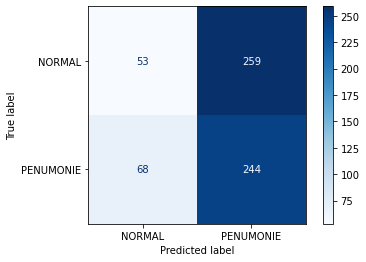

In [43]:
labels = ['NORMAL', 'PNEUMONIE']*312

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

predictions = overfit_model.predict(testing_set, workers=2, max_queue_size=10)
predicted_classes = np.argmax(predictions, axis=1)


# Calculer la matrice de confusion
cm = confusion_matrix(labels_encoded, predicted_classes)

# Afficher la matrice de confusion sous forme de heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PENUMONIE'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [50]:
result = overfit_model.evaluate(testing_set, verbose=1)

20/20 [==============================] - 7s 328ms/step - loss: 0.9185 - accuracy: 0.7532


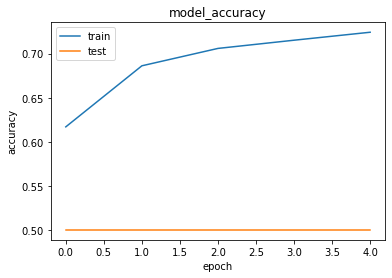

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

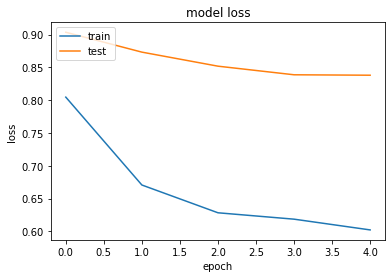

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()